In [13]:
from IPython.display import Image
import os
import pandas as pd
from io import StringIO
import sys
import matplotlib.pyplot as plt

In [14]:
log_file_path = 'D:/GNR_Assgn/training_logs.txt'  # Change the path as needed

log_file = open(log_file_path, 'w')

# Redirect stdout to the log file
sys.stdout = log_file

In [15]:
checkpoint_path = 'D:/GNR_Assgn/model_checkpoint.pth' 

In [16]:
with open('D:/GNR_Assgn/CUB_200_2011/images.txt', 'r') as f:
  images_text = f.read()

with open('D:/GNR_Assgn/CUB_200_2011/train_test_split.txt', 'r') as f:
  train_test = f.read()

with open('D:/GNR_Assgn/CUB_200_2011/image_class_labels.txt', 'r') as f:
  labels_text = f.read()

In [17]:

data_labels=pd.read_csv(StringIO(labels_text), sep=' ', header=None, names=['Number', 'Data'])
data_images=pd.read_csv(StringIO(images_text), sep=' ', header=None, names=['Number', 'Data'])
data_split=pd.read_csv(StringIO(train_test), sep=' ', header=None, names=['Number', 'Data'])

data_labels_column=data_labels['Data']
data_images_column=data_images['Data']
data_split_column=data_split['Data']

df=pd.DataFrame({
    'images':data_images_column,
    'labels': data_labels_column-1,
    'is_train': data_split_column
})

df

images  labels  is_train
0      001.Black_footed_Albatross/Black_Footed_Albatr...       0         0
1      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
2      001.Black_footed_Albatross/Black_Footed_Albatr...       0         0
3      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
4      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
...                                                  ...     ...       ...
11783  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         1
11784  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         0
11785  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         0
11786  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         1
11787  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         0

[11788 rows x 3 columns]

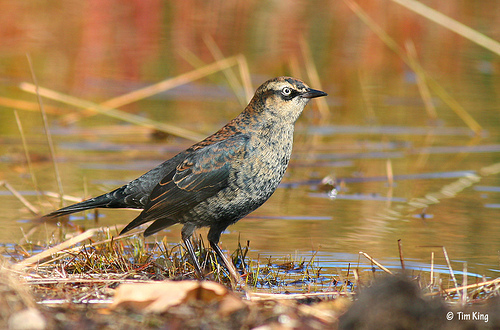

In [18]:
dir_path='D:/GNR_Assgn/CUB_200_2011/images'
# images_path = '/content/drive/MyDrive/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0001_794941.jpg'

image_path=os.path.join(dir_path, df['images'][568])

Image(filename=image_path)

In [19]:
df_train = df[df['is_train']==1]
df_test = df[df['is_train']==0]

In [20]:
df_train

images  labels  is_train
1      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
3      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
4      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
6      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
7      001.Black_footed_Albatross/Black_Footed_Albatr...       0         1
...                                                  ...     ...       ...
11777  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         1
11780  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         1
11781  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         1
11783  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         1
11786  200.Common_Yellowthroat/Common_Yellowthroat_00...     199         1

[5994 rows x 3 columns]

In [21]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

train_data_list = []

for index, row in df_train.iterrows():
    # Assuming 'images' column contains the relative paths
    image_path = os.path.join(dir_path, row['images'])
    label = row['labels']
    train_data_list.append((image_path, label))

test_data_list = []

for index, row in df_test.iterrows():
    # Assuming 'images' column contains the relative paths
    image_path = os.path.join(dir_path, row['images'])
    label = row['labels']
    test_data_list.append((image_path, label))

# Define your transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets using CustomImageDataset
train_dataset = CustomImageDataset(data_list=train_data_list, transform=train_transform)
test_dataset = CustomImageDataset(data_list=test_data_list, transform=test_transform)

# Create DataLoader for training and testing
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


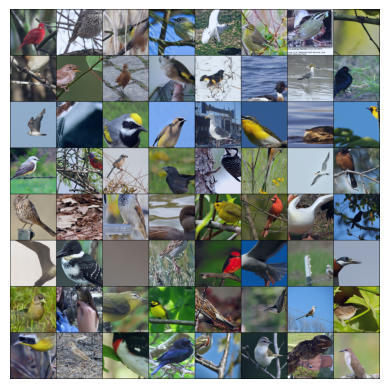

In [22]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

for inputs, labels in train_dataloader:
    # Create a grid of images
    img_grid = vutils.make_grid(inputs, nrow=8, normalize=True)
    # Display the images
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break  # Only visualize the first batch for simplicity


In [23]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
device

device(type='cuda')

In [24]:
import torchvision
import torch.optim as optim
import torch.nn.functional as F

# import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

# Hyperparameters
num_classes = 200
learning_rate = 1e-2
batch_size = 64
num_epochs = 50


In [25]:

class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # Final Block input=(7x7) 
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)
        # END
    
    def forward(self, x):
        
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    
#         x = self.batchnorm2_1_2(self.conv2_1_2(x))                 
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
#         x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
    
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
#         x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
#         x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        
        
        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
#         x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
#         x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)

        
        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_1(self.conv5_2_1(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)


        # FINAL BLOCK - classifier 
        x = self.avgpool(op5)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.out(x)

        return x


In [26]:
resnet18_model = ResNet18(n_classes=200)

resnet18_model.to(device)

ResNet18(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_1): Dropout(p=0.5, inplace=False)
  (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_2): BatchNo

In [27]:
from torchsummary import summary
summary(resnet18_model, (3, 224, 224)) # device="cuda" if torch.cuda.is_available() else "cpu")

In [28]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Set the model to training mode
resnet18_model.train()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet18_model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)

In [29]:
losses_per_epoch = []
accuracies_per_epoch = []

# Train Network
for epoch in range(num_epochs):
    losses = []
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):

        data = data.to(device=device)
        targets = targets.to(device=device)

        scores =resnet18_model(data)

        loss = criterion(scores, targets)

        losses.append(loss.item())
        # backward
        optimizer_ft.zero_grad()
        loss.backward()


        optimizer_ft.step()


        _, predicted_labels = torch.max(scores, 1)
        correct_predictions += (predicted_labels == targets).sum().item()
        total_samples += targets.size(0)
        
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': resnet18_model.state_dict(),
        'optimizer_state_dict': optimizer_ft.state_dict(),
        'loss': loss,  
    }
    torch.save(checkpoint, checkpoint_path)
    # Calculate loss and accuracy for the epoch
    epoch_loss = sum(losses) / len(losses)
    epoch_accuracy = correct_predictions / total_samples

    # Append values to the lists
    losses_per_epoch.append(epoch_loss)
    accuracies_per_epoch.append(epoch_accuracy)

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:42<00:00,  2.20it/s]


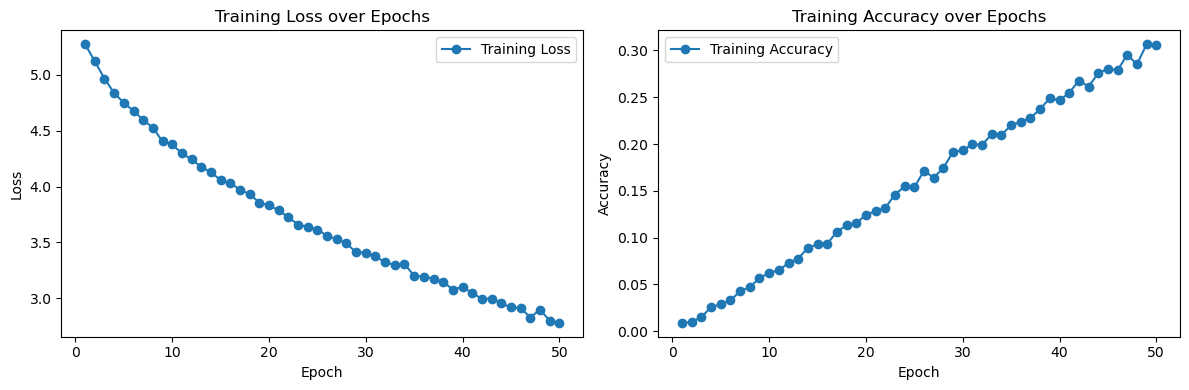

In [30]:
import numpy as np
# Plotting loss and accuracy
epochs = np.arange(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses_per_epoch, label='Training Loss', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies_per_epoch, label='Training Accuracy', marker='o')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Check accuracy on training & test to see how good our model


def check_accuracy(loader, resnet18_model):
    # if loader.dataset.train:
    #     print("Checking accuracy on training data")
    # else:
    #     print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    resnet18_model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = resnet18_model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    resnet18_model.train()
    
check_accuracy(train_dataloader, resnet18_model)

In [32]:
check_accuracy(test_dataloader, resnet18_model)

In [33]:
log_file.close()

sys.stdout = sys.__stdout__